# Multiclass Classification

Recreation of Andrew Ng Octave course 
using Python Jupyter Notebook by Alek Zdziarski

In [1]:
# import key libraries (remember to pip install numpy etc. first)
import numpy as np
import sys
import sklearn as sk
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Setup the parameters you will use for this part of the exercise
input_layer_size  = 400 # 20x20 Input Images of Digits
num_labels = 10;        # 10 labels, from 1 to 10
                        # (note that we have mapped "0" to label 10)


## Part 1: Loading and Visualizing Data

In [3]:
def display_data(s):
    fig, axarr = plt.subplots(nrows=10, ncols=10,figsize=(10,10))    
    for i in range(10):
        for j in range(10):
            ind = np.random.randint(s.shape[0])
            tmp = s[ind,:].reshape(20,20, order='F')
            axarr[i,j].imshow(tmp, cmap='gray_r')
            plt.setp(axarr[i,j].get_xticklabels(), visible=False)
            plt.setp(axarr[i,j].get_yticklabels(), visible=False)
    fig.subplots_adjust(hspace=0, wspace=0)    

Loading and Visualizing Data ...


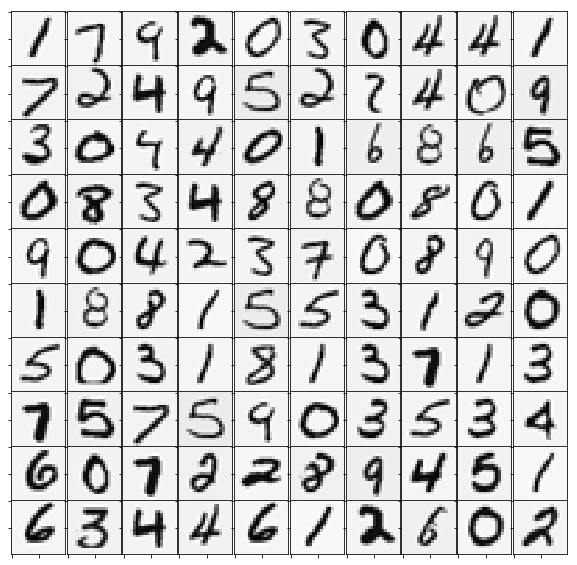

In [4]:
# Load Training Data
print('Loading and Visualizing Data ...')

# import csv data
#PATH="/Users/alek/OneDrive/Projects/Courses/Machine Learning Andrew Ng, Stanford, Coursera/ex3 Multiclass Classification and Neural Nets/ex3/"
PATH="./data/"
DATA="ex3data1.mat"

import scipy.io
mat = scipy.io.loadmat(f'{PATH}{DATA}') # training data stored in arrays X, y
X = mat['X']
y = mat['y']

#convert 10s to 0s as python is 0 indexed so this will be preferred
tenrows = np.where(y==10)
y[tenrows]=0

m = X.shape[0]

# Randomly select 100 data points to display
rand_indices = np.random.permutation(m)
sel = np.asmatrix(X[rand_indices[1:100], :])

display_data(sel)

## Part 2a: Vectorize Logistic Regression

In [5]:
def sigmoid(z):
    return 1/(1+ np.exp(-z))

def lr_cost_function_reg(theta, X, y, Lambda):
    m = y.size
    polynomial = X@theta # going straight for all xs rather than x^(i) one by one
    hypothesis = sigmoid(polynomial)
    cost = -y*np.log(hypothesis)-(1-y)*np.log(1-hypothesis)
    #regularization
    n=theta.size
    regularization=Lambda/2/m*np.sum(theta[1:n]**2) #remember that we dont regularize theta_0 which is 1 indexed in octave
    J=np.mean(cost)+regularization
    grad = X.T@(hypothesis-y)/m
    grad_regularizations = Lambda/m*theta
    grad_regularizations[0] = 0 # remember we don't regularize our theta_0
    grad = grad + grad_regularizations   
    return J, grad

theta_t = np.matrix('[-2.; -1.; 1.; 2.]').A #use matrix convenience function to use matlab formatted matrix string 
X_t = np.c_[np.ones((5,1)), np.arange(1,16).reshape(3,5).T/10] # note difference in order of filled by reshape
y_t = np.matrix('[1.;0.;1.;0.;1.]').A # again the little trick
lambda_t = 3.
[J, grad] = lr_cost_function_reg (theta_t, X_t, y_t, lambda_t)
J, grad

(2.5348193961097438, array([[ 0.14656137],
        [-0.54855841],
        [ 0.72472227],
        [ 1.39800296]]))

In [6]:
print('Cost: ', J);
print('Expected cost: 2.534819');
print('Gradients:');
print('', grad);
print('Expected gradients:');
print(' 0.146561\n -0.548558\n 0.724722\n 1.398003\n');


Cost:  2.53481939611
Expected cost: 2.534819
Gradients:
 [[ 0.14656137]
 [-0.54855841]
 [ 0.72472227]
 [ 1.39800296]]
Expected gradients:
 0.146561
 -0.548558
 0.724722
 1.398003



# Part 2b: One-vs-All Training 

In [7]:
def costf(theta, X, y, Lambda, n):
    theta = theta.reshape((n+1,1))
    return lr_cost_function_reg(theta, X, y, Lambda)[0]
def gradf(theta, X, y, Lambda, n):
    theta = theta.reshape((n+1,1))
    #print(f'{theta} {theta.shape}')
    ret = lr_cost_function_reg(theta, X, y, Lambda)[1]
    return ret



In [8]:
import scipy.optimize as opt  

In [9]:
def oneVsAll(X, y, num_labels, Lambda): 
#ONEVSALL trains multiple logistic regression classifiers and returns all
#the classifiers in a matrix all_theta, where the i-th row of all_theta
#corresponds to the classifier for label i
#   [all_theta] = ONEVSALL(X, y, num_labels, lambda) trains num_labels
#   logistic regression classifiers and returns each of these classifiers
#   in a matrix all_theta, where the i-th row of all_theta corresponds
#   to the classifier for label i

    m = X.shape[0] #size(X, 1);
    n = X.shape[1] #size(X, 2);

    # Add ones to the X data matrix
    X = np.c_[np.ones((m, 1)), X]
    k = num_labels

    cm=np.arange(0,k)

    ys = ((y*np.ones((m, k))) == cm).T # one vs. all training sets. make a row for every exclusive label

    # Set Initial theta
    initial_theta = np.zeros((n + 1, 1))

    # Set options for fminunc
    #options = optimset('GradObj', 'on', 'MaxIter', 50);

    thetas=np.zeros((k, n+1))

    for c in np.arange(k):
        #thetas[c] = 
        #print (opt.fmin_tnc(func=lr_cost_function_reg, x0=initial_theta, args=(X, y, Lambda)))
        thetas[c] = (opt.fmin_tnc(func=costf, x0=initial_theta, fprime=gradf, args=(X, ys[c].reshape(m,1)*1., Lambda,n)))[0]
        #thetas(c,:) = (fmincg (@(t)(lrCostFunction(t, X, ys(c,:)', lambda)), initial_theta, options));
    return thetas

In [10]:
Lambda = 0.1
all_theta = oneVsAll(X, y, num_labels, Lambda)

In [11]:
all_theta.shape, X.shape

((10, 401), (5000, 400))

# Part 3: Predict for One-Vs-All

In [12]:
def predictOneVsAll(all_theta, X):
    #PREDICT Predict the label for a trained one-vs-all classifier. The labels
    #are in the range 1..K, where K = size(all_theta, 1).
    #  p = PREDICTONEVSALL(all_theta, X) will return a vector of predictions
    #  for each example in the matrix X. Note that X contains the examples in
    #  rows. all_theta is a matrix where the i-th row is a trained logistic
    #  regression theta vector for the i-th class. You should set p to a vector
    #  of values from 1..K (e.g., p = [1; 3; 1; 2] predicts classes 1, 3, 1, 2
    #  for 4 examples)
    m = X.shape[0]
    num_labels = all_theta.shape[0]
    
    # Add ones to the X data matrix
    X = np.c_[np.ones((m, 1)), X]
    
    hypotheses = sigmoid(X@all_theta.T)
    #print(hypotheses.shape)
    value=np.argmax(hypotheses, axis=1)
    #print(value)
    #[probability value] = max(hypotheses.T)
    return value


In [13]:
pred = predictOneVsAll(all_theta, X).reshape(m,1)

In [14]:
a=np.random.choice(5000,10)
print (f'y {y[a].ravel()}, prediction {pred[a].ravel()}')

y [4 3 6 8 8 9 4 1 1 6], prediction [4 3 6 6 8 6 4 1 1 6]


In [15]:
print(f'Training Set Accuracy: {np.mean(np.double(pred == y)) * 100}')

Training Set Accuracy: 96.46000000000001
